# ACE estimations from real observational data
*This notebook examines the use of the `CausalEffectEstimation` module for estimating Average Causal Effects (ACE) in Observational Studies within the Neyman-Rubin potential outcome framework from real data:* [N. Antonio et al. (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191)

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.discretizer as disc

import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Dataset
The data used in this notbook come from "Hotel booking demand datasets" by N. Antonio et al.
The data contains 31 variables describing the 104,641 observations. Each observation represents a hotel booking.

We aim to study the impact of assigning a different room to a customer on its likelihood to cancel the reservation. 
Here, some data preprocessing is needed to match our objectives.

In [3]:
df = pd.read_csv("../data/hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# Total stay in nights
df['total_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

# Total number of guests
df['guests'] = df['adults'] + df['children'] + df['babies']

# Creating the different_room_assigned feature
df['different_room_assigned'] = 0
slice_indices = df['reserved_room_type'] != df['assigned_room_type']
df.loc[slice_indices,'different_room_assigned'] = 1

# Deleting older features
df = df.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children',
                   'babies','reserved_room_type','assigned_room_type'],axis=1)

df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [5]:
print(f"Number of Null entries: {df.isnull().sum()}")
df = df.drop(['agent','company'],axis=1)

# Replacing missing countries with most freqently occuring countries
df['country']= df['country'].fillna(df['country'].mode()[0])
df['guests']= df['guests'].fillna(df['guests'].mode()[0]).astype(int)

df = df.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
df = df.drop(['arrival_date_year'],axis=1)
df = df.drop(['distribution_channel'], axis=1)

Number of Null entries: hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status               

In [6]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
df['different_room_assigned'] = df['different_room_assigned'].astype(int)
df['is_canceled']= df['is_canceled'].astype(int)
df.dropna(inplace=True)
print(df.columns)
df.iloc[:, 5:20].head()

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.0,0,0,0,2
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.0,0,0,0,2
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.0,0,0,1,1
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.0,0,0,1,1
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.0,0,1,2,2


In [33]:
df['hotel'] = (df['hotel'] == 'City Hotel').astype(int)

In [7]:
df = df[df.deposit_type=="No Deposit"]
df.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  arrival_date_month  \
deposit_type is_canceled                                         
No Deposit   0            74947      74947               74947   
             1            29694      29694               29694   

                          arrival_date_week_number   meal  country  \
deposit_type is_canceled                                             
No Deposit   0                               74947  74947    74947   
             1                               29694  29694    29694   

                          market_segment  is_repeated_guest  \
deposit_type is_canceled                                      
No Deposit   0                     74947              74947   
             1                     29694              29694   

                          previous_cancellations  \
deposit_type is_canceled                           
No Deposit   0                             74947   
             1                             29694   

                          previous_bookings_not_canceled  booking_changes  \
deposit_type is_canceled                                                    
No Deposit   0                                     74947            74947   
             1                                     29694            29694   

                          days_in_waiting_list  customer_type    adr  \
deposit_type is_canceled                                               
No Deposit   0                           74947          74947  74947   
             1                           29694          29694  29694   

                          required_car_parking_spaces  \
deposit_type is_canceled                                
No Deposit   0                                  74947   
             1                                  29694   

                          total_of_special_requests  total_stay  guests  \
deposit_type is_canceled                                                  
No Deposit   0                                74947       74947   74947   
             1                                29694       29694   29694   

                          different_room_assigned  
deposit_type is_canceled                           
No Deposit   0                              74947  
             1                              29694

In [8]:
counts_sum=0
for i in range(1,1000):
        counts_i = 0
        rdf = df.sample(1000)
        counts_i = rdf[rdf["is_canceled"] == rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
print(f"Percentage of customers with different room assignment and cancelation : {counts_sum/1000000}")

Percentage of customers with different room assignment and cancelation : 0.588156


In [9]:
# Expected Count when there are no booking changes 
counts_sum=0
for i in range(1,1000):
        counts_i = 0
        rdf = df[df["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"] == rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/1000000
print(f"Percentage of customers with different room assignment and cancelation when there are no booking changes : {counts_sum/1000000}")

Percentage of customers with different room assignment and cancelation when there are no booking changes : 0.572349


In [10]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,1000):
        counts_i = 0
        rdf = df[df["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/1000000
print(f"Percentage of customers with different room assignment and cancelation when there are booking changes : {counts_sum/1000000}")

Percentage of customers with different room assignment and cancelation when there are booking changes : 0.664745


In [11]:
df = df.drop(columns=["customer_type", "arrival_date_month", "arrival_date_week_number", "adr", "previous_cancellations", "deposit_type"])

We observe that changes in a customer's booking may influence the probability of different room assignments and booking cancellations. We will now investigate whether a causal relationship exists between these factors.

### Bayesian Network Preparation
We use `skbn.BNDiscretizer` to discretize the continous variables found in the dataset. The structure of the network will also be provided.

In [12]:
for var in df.select_dtypes(include='number').columns:
    print(var, df[var].nunique())

is_canceled 2
lead_time 431
is_repeated_guest 2
previous_bookings_not_canceled 73
booking_changes 21
days_in_waiting_list 99
required_car_parking_spaces 5
total_of_special_requests 6
total_stay 45
guests 15
different_room_assigned 2


In [13]:
discretizer = disc.Discretizer(defaultNumberOfBins=5, defaultDiscretizationMethod="kmeans") #uniform causes the kernel to crash

discretizer.setDiscretizationParameters(variableName="lead_time", method="quantile")
discretizer.setDiscretizationParameters(variableName="is_repeated_guest", method="NoDiscretization")
discretizer.setDiscretizationParameters(variableName="previous_bookings_not_canceled", method="kmeans")
discretizer.setDiscretizationParameters(variableName="booking_changes", method="kmeans", paramDiscretizationMethod=5)
discretizer.setDiscretizationParameters(variableName="days_in_waiting_list", method="kmeans", paramDiscretizationMethod=5)
discretizer.setDiscretizationParameters(variableName="guests", method="kmeans", paramDiscretizationMethod=5)
discretizer.setDiscretizationParameters(variableName="total_stay", method="quantile")

template = discretizer.discretizedTemplate(df)

/home/thierry/.local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [14]:
template.addArc("market_segment", "lead_time")
template.addArc("lead_time", "is_canceled")
template.addArc("country", "lead_time")
template.addArc("different_room_assigned", "is_canceled")
template.addArc("country", "meal")
template.addArc("lead_time", "days_in_waiting_list")
template.addArc("days_in_waiting_list", "is_canceled")
template.addArc("days_in_waiting_list", "different_room_assigned")
template.addArc("previous_bookings_not_canceled", "is_canceled")
template.addArc("previous_bookings_not_canceled", "is_repeated_guest")
template.addArc("is_repeated_guest", "different_room_assigned")
template.addArc("is_repeated_guest", "is_canceled")
template.addArc("total_stay", "is_canceled")
template.addArc("guests", "is_canceled")
template.addArc("booking_changes", "different_room_assigned")
template.addArc("booking_changes", "is_canceled")
template.addArc("hotel", "different_room_assigned")
template.addArc("hotel", "is_canceled")
template.addArc("required_car_parking_spaces", "is_canceled")
template.addArc("total_of_special_requests", "booking_changes")
template.addArc("total_of_special_requests", "is_canceled")
template.addArc("country", "hotel")
template.addArc("country", "required_car_parking_spaces")
template.addArc("country", "total_of_special_requests")
template.addArc("market_segment", "hotel")
template.addArc("market_segment", "required_car_parking_spaces")
template.addArc("market_segment", "total_of_special_requests")

### Causal Model
A causal Baysian Network is then created using `csl.CausalModel`, a latent variable being the cause of multiple covariates is also added.

In [15]:
causal_model = csl.CausalModel(template, [("U", ["total_of_special_requests", "required_car_parking_spaces", "total_stay", "guests"])])

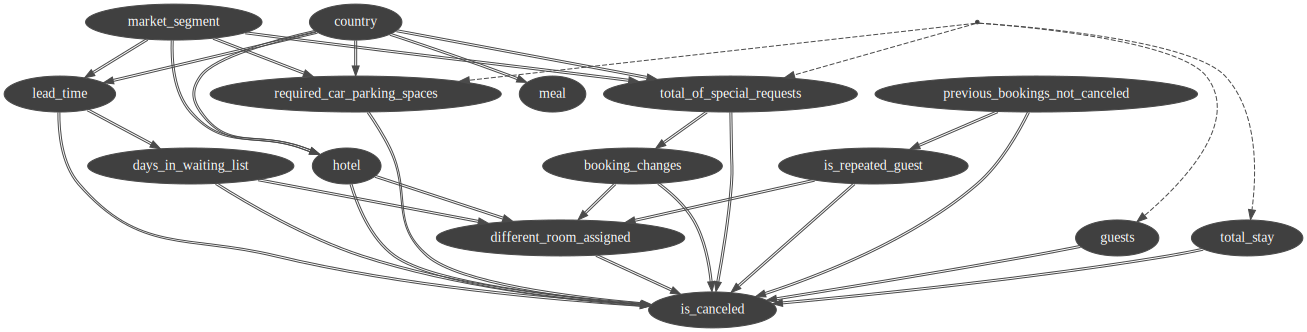

In [16]:
cslnb.showCausalModel(causal_model, size="50")

In [17]:
T = "different_room_assigned"
Y = "is_canceled"

### Identificationa and estimation

In [34]:
cee = csl.CausalEffectEstimation(df, causal_model)

In [37]:
cee.identifyAdjustmentSet(intervention=T, outcome=Y)
# Instrumental Variable Algorithm takes 7min  

Backdoor adjustment found. 

Supported estimators include:
- CausalModelEstimator
- SLearner
- TLearner
- XLearner
- PStratification
- IPW


'Backdoor'

In [47]:
print(f"Covariates: {cee._X}")
df[[*cee._X]].describe()

Covariates: {'days_in_waiting_list', 'hotel', 'is_repeated_guest', 'booking_changes'}


,days_in_waiting_list,hotel,is_repeated_guest,booking_changes
count,104641.000000,104641.000000,104641.000000,104641.000000
mean,1.519347,0.634952,0.035760,0.249634
std,14.989614,0.481446,0.185693,0.689376
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000
max,379.000000,1.000000,1.000000,21.000000


In [39]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = -0.2555237959404865


In [40]:
cee.fitXLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = -0.2691332975169325


In [41]:
cee.fitIPW()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = -0.27029139705955163


We observe a negative Average Causal Effect, which is counterintuitive, as it suggests that assigning a different room reduces the likelihood of a reservation cancellation. To explore this further, we will examine the Conditional Average Causal Effect (CACE) by conditioning on the covariates to provide additional insights. To do so, we use a pandas query string to condition on the relevant variables.

# CATE estimations

In [44]:
cee.fitTLearner()
tau_hat = cee.estimateCausalEffect(conditional="hotel == 1")

print(f"ACE = {tau_hat}")

ACE = -0.2797360230520657


In [45]:
cee.fitTLearner()
tau_hat = cee.estimateCausalEffect(conditional="is_repeated_guest == 1")

print(f"ACE = {tau_hat}")

ACE = -0.1304771865329171


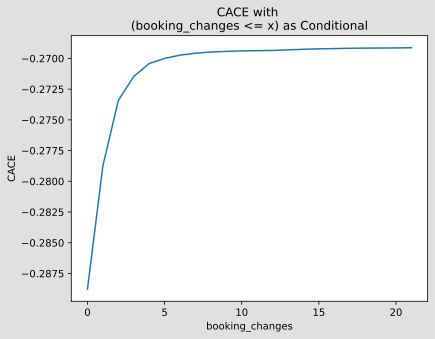

In [55]:
cee.fitTLearner()
changes = sorted(df["booking_changes"].unique())
booking = list()

for i in changes:
    tau_hat = cee.estimateCausalEffect(conditional=f"booking_changes <= {i}")
    booking.append(tau_hat)

plt.plot(changes, booking)
plt.title("CACE with \n(booking_changes <= x) as Conditional")
plt.xlabel("booking_changes")
plt.ylabel("CACE")
plt.show()

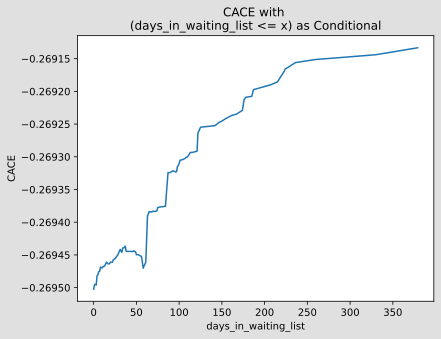

In [56]:
cee.fitTLearner()
changes = sorted(df["days_in_waiting_list"].unique())
booking = list()

for i in changes:
    tau_hat = cee.estimateCausalEffect(conditional=f"days_in_waiting_list <= {i}")
    booking.append(tau_hat)

plt.plot(changes, booking)
plt.title("CACE with \n(days_in_waiting_list <= x) as Conditional")
plt.xlabel("days_in_waiting_list")
plt.ylabel("CACE")
plt.show()

Overall, the analysis continues to indicate a negative Average Causal Effect (ACE). However, a more detailed examination of the conditional factors reveals that customers who planned their trips further in advance—reflected by more booking changes and extended waiting list durations—exhibit a Complier Average Causal Effect (CACE) closer to zero. In contrast, more spontaneous customers tend to show a stronger negative effect.